In [2]:
import matplotlib.pyplot as plt
import pandas as pd

2025-03-24 14:29:37.917472 2025-03-24 14:44:22.310798080


<Figure size 1200x800 with 0 Axes>

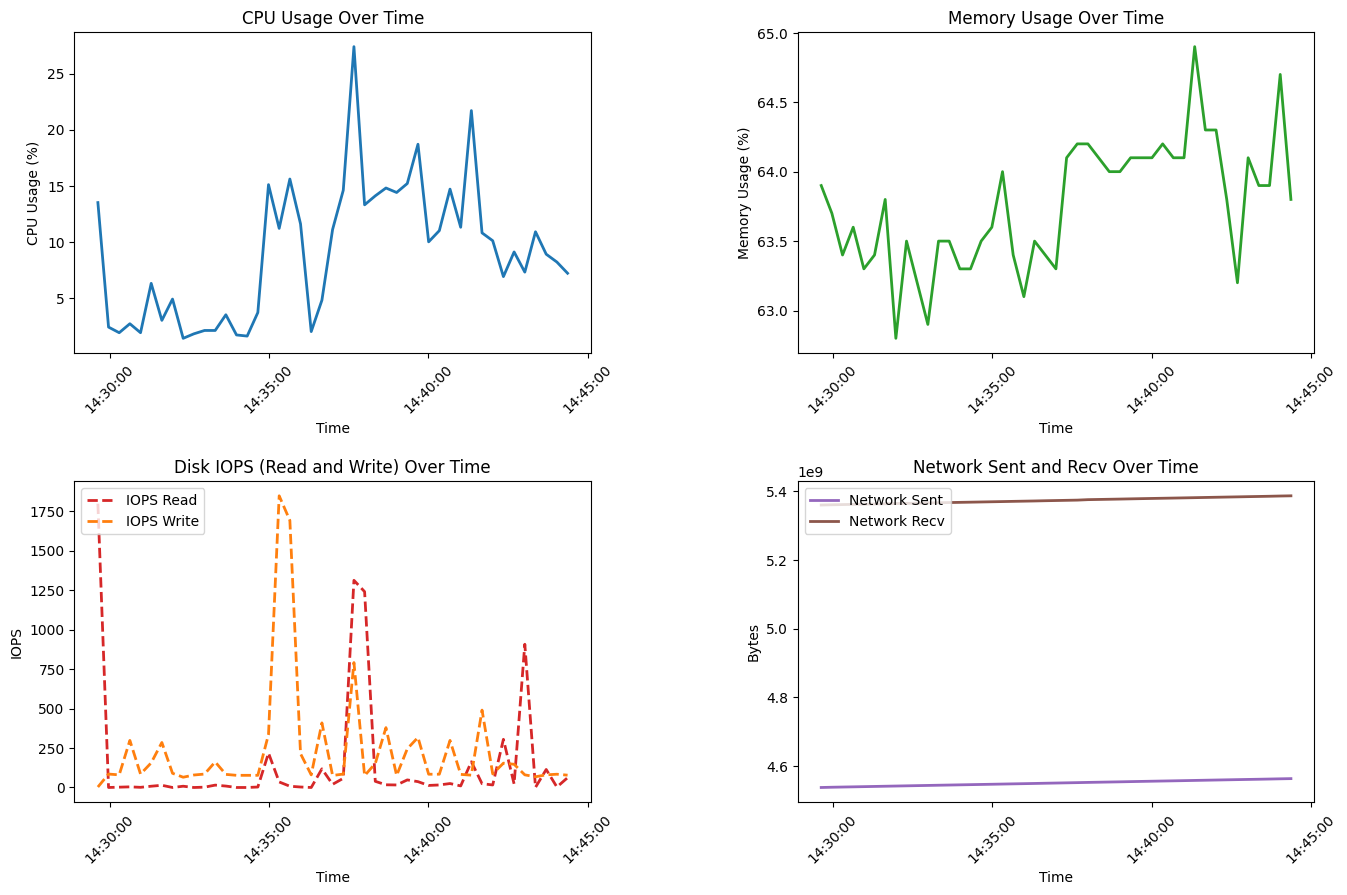

In [3]:
# Read the data into a pandas DataFrame
df = pd.read_csv('metrics_during_stress_test.csv')

# Convert the 'Time' column to datetime format for better plotting
df['Time'] = pd.to_datetime(df['Time'], unit='s')

N = 10  # Adjust this number to plot fewer points
df = df.iloc[::N, :]

print(df['Time'].min(), df['Time'].max()) 

# Plot the data
plt.figure(figsize=(12, 8))

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: CPU Usage
axs[0, 0].plot(df['Time'], df['CPU Usage'], label='CPU Usage', color='tab:blue', linewidth=2)
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('CPU Usage (%)')
axs[0, 0].set_title('CPU Usage Over Time')
axs[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Memory Usage
axs[0, 1].plot(df['Time'], df['Memory Usage'], label='Memory Usage', color='tab:green', linewidth=2)
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Memory Usage (%)')
axs[0, 1].set_title('Memory Usage Over Time')
axs[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Disk IOPS (Read and Write)
axs[1, 0].plot(df['Time'], df['IOPS Read'], label='IOPS Read', color='tab:red', linestyle='--', linewidth=2)
axs[1, 0].plot(df['Time'], df['IOPS Write'], label='IOPS Write', color='tab:orange', linestyle='--', linewidth=2)
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('IOPS')
axs[1, 0].set_title('Disk IOPS (Read and Write) Over Time')
axs[1, 0].legend(loc='upper left')
axs[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Network Sent and Recv
axs[1, 1].plot(df['Time'], df['Network Sent'], label='Network Sent', color='tab:purple', linewidth=2)
axs[1, 1].plot(df['Time'], df['Network Recv'], label='Network Recv', color='tab:brown', linewidth=2)
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Bytes')
axs[1, 1].set_title('Network Sent and Recv Over Time')
axs[1, 1].legend(loc='upper left')
axs[1, 1].tick_params(axis='x', rotation=45)

for ax in axs.flat:
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M:%S'))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Show the plots
plt.show()